# Setup & imports

In [1]:
!pip -q install "gymnasium[atari,accept-rom-license]" stable-baselines3[extra] ale-py shimmy

In [12]:
import os, time, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.atari_wrappers import AtariWrapper
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import set_random_seed

In [13]:
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)
print("ALE registered ✅")

ALE registered ✅


In [14]:
ENV_ID = "ALE/Tennis-v5"
TOTAL_TIMESTEPS = 30_000
EVAL_EPISODES = 5
SEEDS = [0, 1, 2]

LOG_DIR = "./logs_tennis"
MODELS_DIR = "./models_tennis"
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

In [ ]:
def make_env(env_id=ENV_ID, seed=0):
    def _init():
        env = gym.make(env_id)
        env = Monitor(env)
        env = AtariWrapper(env)  # preprocess Atari standard (resize/frameskip/clip/...)
        env.reset(seed=seed)
        env.action_space.seed(seed)
        return env
    return _init

def make_vec_env(seed=0, n_stack=4):
    set_random_seed(seed)
    venv = DummyVecEnv([make_env(seed=seed)])
    venv = VecFrameStack(venv, n_stack=n_stack)
    return venv

: 

In [5]:
venv = make_vec_env(seed=0)
obs = venv.reset()
print("obs shape:", obs.shape)   # (1, 4, 84, 84) en général
print("action space:", venv.action_space)

obs shape: (1, 84, 84, 4)
action space: Discrete(18)


In [6]:
from stable_baselines3.common.callbacks import BaseCallback

class EvalCallbackSimple(BaseCallback):
    def __init__(self, eval_env, eval_freq=20_000, n_eval_episodes=10, seed=0, verbose=0):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes
        self.seed = seed
        self.history = []  # list of dicts

    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            print(f"[EVAL] t={self.num_timesteps}")
            mean_r, std_r = evaluate_policy(
                self.model, self.eval_env,
                n_eval_episodes=self.n_eval_episodes,
                deterministic=True,
                return_episode_rewards=False,
            )
            self.history.append({
                "timesteps": self.num_timesteps,
                "mean_reward": float(mean_r),
                "std_reward": float(std_r),
                "seed": self.seed
            })
        return True

In [ ]:
def train_dqn(seed=0):
    print("\n" + "="*50)
    print(f"[START] DQN | seed {seed}")
    print("="*50)

    t_seed = time.time()

    print("[INFO] Creating environments...")
    env = make_vec_env(seed=seed)
    eval_env = make_vec_env(seed=seed + 100)

    print("[INFO] Initializing DQN model...")
    model = DQN(
        "CnnPolicy",
        env,
        learning_rate=1e-4,
        buffer_size=20_000,
        learning_starts=2_000,
        batch_size=32,
        gamma=0.99,
        train_freq=4,
        gradient_steps=1,
        target_update_interval=10_000,
        exploration_fraction=0.20,
        exploration_final_eps=0.01,
        verbose=0,
        seed=seed,
    )

    cb = EvalCallbackSimple(eval_env, eval_freq=10_000, n_eval_episodes=3, seed=seed)

    print("[TRAIN] Starting learning...")
    t0 = time.time()
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=cb, progress_bar=True)
    learn_time = time.time() - t0
    print(f"[TIME] Training time: {learn_time/60:.2f} min")

    print("[EVAL] Final evaluation...")
    t1 = time.time()
    final_mean, final_std = evaluate_policy(
        model, eval_env,
        n_eval_episodes=EVAL_EPISODES,
        deterministic=True
    )
    eval_time = time.time() - t1
    print(f"[TIME] Final eval time: {eval_time:.1f} s")

    print("[CLEANUP] Closing envs & freeing memory...")
    env.close()
    eval_env.close()
    del model, env, eval_env
    gc.collect()

    seed_time = time.time() - t_seed
    print(f"[END] DQN | seed {seed} | total time: {seed_time/60:.2f} min")

    return cb.history, {
        "algo": "DQN",
        "seed": seed,
        "final_mean": float(final_mean),
        "final_std": float(final_std),
        "learn_time_s": float(learn_time),
        "eval_time_s": float(eval_time),
        "seed_time_s": float(seed_time),
    }


In [ ]:
def train_ppo(seed=0):
    print("\n" + "="*50)
    print(f"[START] PPO | seed {seed}")
    print("="*50)

    t_seed = time.time()

    print("[INFO] Creating environments...")
    env = make_vec_env(seed=seed)
    eval_env = make_vec_env(seed=seed + 100)

    print("[INFO] Initializing PPO model...")
    model = PPO(
        "CnnPolicy",
        env,
        learning_rate=2.5e-4,
        n_steps=128,
        batch_size=128,
        n_epochs=4,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.1,
        ent_coef=0.01,
        vf_coef=0.5,
        max_grad_norm=0.5,
        verbose=0,
        seed=seed,
    )

    cb = EvalCallbackSimple(eval_env, eval_freq=10_000, n_eval_episodes=3, seed=seed)

    print("[TRAIN] Starting learning...")
    t0 = time.time()
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=cb, progress_bar=True)
    learn_time = time.time() - t0
    print(f"[TIME] Training time: {learn_time/60:.2f} min")

    print("[EVAL] Final evaluation...")
    t1 = time.time()
    final_mean, final_std = evaluate_policy(
        model, eval_env,
        n_eval_episodes=EVAL_EPISODES,
        deterministic=True
    )
    eval_time = time.time() - t1
    print(f"[TIME] Final eval time: {eval_time:.1f} s")

    print("[CLEANUP] Closing envs & freeing memory...")
    env.close()
    eval_env.close()
    del model, env, eval_env
    gc.collect()

    seed_time = time.time() - t_seed
    print(f"[END] PPO | seed {seed} | total time: {seed_time/60:.2f} min")

    return cb.history, {
        "algo": "PPO",
        "seed": seed,
        "final_mean": float(final_mean),
        "final_std": float(final_std),
        "learn_time_s": float(learn_time),
        "eval_time_s": float(eval_time),
        "seed_time_s": float(seed_time),
    }



In [9]:
all_hist = []
summary = []

for seed in SEEDS:
    h, s = train_dqn(seed)
    all_hist += [dict(**row, algo="DQN") for row in h]
    summary.append(s)

for seed in SEEDS:
    h, s = train_ppo(seed)
    all_hist += [dict(**row, algo="PPO") for row in h]
    summary.append(s)

hist_df = pd.DataFrame(all_hist)
sum_df = pd.DataFrame(summary)
sum_df

Output()

[EVAL] t=10000

[EVAL] t=20000

[EVAL] t=30000

Output()

[EVAL] t=10000

[EVAL] t=20000

[EVAL] t=30000

Output()

[EVAL] t=10000

[EVAL] t=20000

[EVAL] t=30000

c:\Users\enzol\anaconda3\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 256, but because the `RolloutBuffer` is of size `n_steps * n_envs = 128`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 128
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=128 and n_envs=1)
  warnings.warn(


Output()

[EVAL] t=10000

[EVAL] t=20000

[EVAL] t=30000

Output()

[EVAL] t=10000

[EVAL] t=20000

[EVAL] t=30000

Output()

[EVAL] t=10000

[EVAL] t=20000

[EVAL] t=30000

,algo,seed,final_mean,final_std,model_path
0,DQN,0,-1.0,0.00000,./models_tennis/dqn_seed0.zip
1,DQN,1,-8.0,0.00000,./models_tennis/dqn_seed1.zip
2,DQN,2,-1.0,0.00000,./models_tennis/dqn_seed2.zip
3,PPO,0,-1.0,0.00000,./models_tennis/ppo_seed0.zip
4,PPO,1,-0.9,0.43589,./models_tennis/ppo_seed1.zip
5,PPO,2,-1.0,0.00000,./models_tennis/ppo_seed2.zip


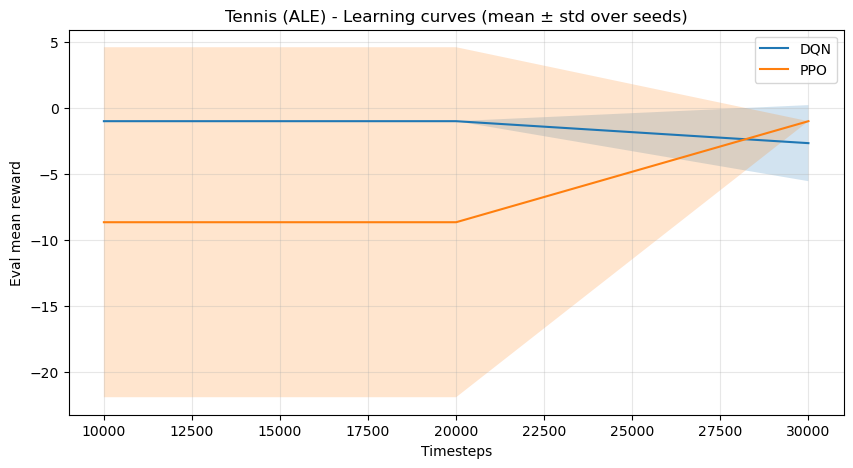

In [10]:
def plot_learning_curves(df):
    plt.figure(figsize=(10,5))
    for algo in df["algo"].unique():
        sub = df[df["algo"] == algo].copy()
        # moyenne par timestep sur seeds
        g = sub.groupby("timesteps")["mean_reward"]
        mean = g.mean()
        std = g.std().fillna(0)
        plt.plot(mean.index, mean.values, label=algo)
        plt.fill_between(mean.index, (mean-std).values, (mean+std).values, alpha=0.2)
    plt.xlabel("Timesteps")
    plt.ylabel("Eval mean reward")
    plt.title("Tennis (ALE) - Learning curves (mean ± std over seeds)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_learning_curves(hist_df)

In [11]:
final_table = (
    sum_df.groupby("algo")
    .agg(
        final_mean_avg=("final_mean", "mean"),
        final_mean_std=("final_mean", "std"),
        final_std_avg=("final_std", "mean"),
        runs=("seed","count"),
    )
    .reset_index()
)

final_table

,algo,final_mean_avg,final_mean_std,final_std_avg,runs
0,DQN,-3.333333,4.041452,0.000000,3
1,PPO,-0.966667,0.057735,0.145297,3
